In [1]:
# Load libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import sys
import string
import json
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import sklearn
import _pickle as cPickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

In [2]:
# Load dataset
TwtDs = pd.read_csv('C:\\Users\\Mlin\\OneDrive\\Documents\\tamu\\DataScience\\twitter-user-gender-classification\\gender-classifier-DFE-791531.csv',  na_values=['.'], encoding = "ISO-8859-1")

In [3]:
# shape
print(TwtDs.shape) 

(20050, 26)


In [4]:
# head
print(TwtDs.head(10))

    _unit_id _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  815719226   False   finalized                   3    10/26/15 23:24   
1  815719227   False   finalized                   3    10/26/15 23:30   
2  815719228   False   finalized                   3    10/26/15 23:33   
3  815719229   False   finalized                   3    10/26/15 23:10   
4  815719230   False   finalized                   3     10/27/15 1:15   
5  815719231   False   finalized                   3     10/27/15 1:47   
6  815719232   False   finalized                   3     10/27/15 1:57   
7  815719233   False   finalized                   3    10/26/15 23:48   
8  815719234   False   finalized                   3     10/27/15 1:52   
9  815719235   False   finalized                   3     10/27/15 1:49   

   gender  gender:confidence profile_yn  profile_yn:confidence  \
0    male             1.0000        yes                    1.0   
1    male             1.0000        yes              

In [5]:
# Add a text length column to the dataset
TwtDs['txtlength'] = TwtDs['text'].map(lambda text: len(text))

In [6]:
# Dataset Info
TwtDs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 27 columns):
_unit_id                 20050 non-null int64
_golden                  20050 non-null bool
_unit_state              20050 non-null object
_trusted_judgments       20050 non-null int64
_last_judgment_at        20000 non-null object
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
created                  20050 non-null object
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
profileimage             20050 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text    

In [7]:
# Only select the female or male records from the dataset
TwtFm = TwtDs[(TwtDs['gender']=='female') | (TwtDs['gender']=='male')]
TwtFm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12894 entries, 0 to 20049
Data columns (total 27 columns):
_unit_id                 12894 non-null int64
_golden                  12894 non-null bool
_unit_state              12894 non-null object
_trusted_judgments       12894 non-null int64
_last_judgment_at        12858 non-null object
gender                   12894 non-null object
gender:confidence        12894 non-null float64
profile_yn               12894 non-null object
profile_yn:confidence    12894 non-null float64
created                  12894 non-null object
description              11194 non-null object
fav_number               12894 non-null int64
gender_gold              36 non-null object
link_color               12894 non-null object
name                     12894 non-null object
profile_yn_gold          36 non-null object
profileimage             12894 non-null object
retweet_count            12894 non-null int64
sidebar_color            12894 non-null object
text    

In [8]:
TwtFm.txtlength.describe()

count    12894.000000
mean        96.867458
std         33.838490
min          6.000000
25%         70.000000
50%        100.000000
75%        128.000000
max        425.000000
Name: txtlength, dtype: float64

In [9]:
# check the longest tweet in the dataset
print (list(TwtFm.text[TwtDs.txtlength > 400]))

['When You A Trap Wife and Everybody wants you _Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷__Ù÷_']


In [10]:
# check the shortest tweet in the dataset
print (list(TwtFm.text[TwtDs.txtlength < 10]))

['#NAME?', 'And fever']


In [11]:
# Take a random sample of 2000 from the dataset
TwtSam2000 = TwtFm.sample(2000, random_state=123)

In [12]:
# gender distribution
print(TwtSam2000.groupby('gender').size())

gender
female    1061
male       939
dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019C4E48B080>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000019C4DF12FD0>], dtype=object)

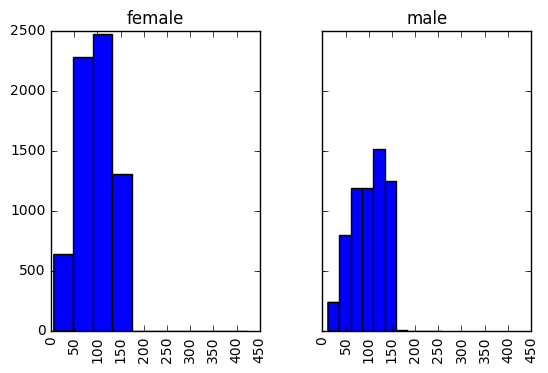

In [13]:
# check the tweet length by gender
TwtFm.hist(column='txtlength', by='gender', bins=10, sharex=True, sharey=True)

In [14]:
# Define a function utilzing nltk's TweetTokenizer(), stopwords=[]
def process(text, tokenizer=TweetTokenizer(), stopwords=[]):
    """Process the text of a tweet:
    - Lowercase
    - Tokenize
    - Stopword removal
    - Digits removal
    Return: list of strings
    """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    # If we want to normalize contraction, uncomment this
    # tokens = normalize_contractions(tokens)
    return [tok for tok in tokens if tok not in stopwords and not tok.isdigit()]

In [15]:
# Create bag of words from the sampled 2000 tweets
topbow_transformer = CountVectorizer(analyzer=process).fit(TwtSam2000['text'])
print (len(topbow_transformer.vocabulary_))

8409


In [16]:
topbow_transformer.vocabulary_.keys()

dict_keys(['#ukip', '@mikechipperson', 'https://t.co/r2ilsty02w', '#customersuccess', 'https://t.co/xvyzkfaysj', 'https://t.co/kaa28tsu7k', 'drained', 'joce', 'https://t.co/gvrr88dkfw', 'ditches', 'fat', 'aye', 'bottom', 'forget', 'pushchair', 'ð', '@zodiacforest', 'appreciated', '@bmanbushur', 'tube', 'secondly', '@justinbieber', 'than', 'cdc', 'leslie', 'cigarette', '#justplayingbustnuts', 'sales', 'procedure', 'knife', 'shopper', 'ó', '4:55', 'chance', 'sutton', 'sonny', 'conjure', 'â_ùð', '@grimezsz', '@amoshay25', '@feigle_95', 'tl', 'spangled', 'gift', 'motivation', 'zindzi', 'tacked', 'bit', '@gonision', 'louise', "hadn't", 'pics', 'deletes', 'https://t.co/iavra8gvhf', 'dnc', 'spotted', 'snapchat', '#rolexskydweller', 'b', 'reno', 'kyle', 'journal', 'iron', 'sets', 'https://t.co/8oteoi0bwm', 'https://t.co/9xdpew2ubs', 'https://t.co/fsneadgntl', 'https://t.co/qmljesazad', '#rwc2015', 'mighty', '@manutd', 'stalking', 'sophisti', 'windy', '108,652', 'minute', 'winter', '#otrabirmin

In [17]:
# generate bag of words for the sampled tweets
TwtSam_bow = topbow_transformer.transform(TwtSam2000['text'])
print ('sparse matrix shape:', TwtSam_bow.shape)
print ('number of non-zeros:', TwtSam_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * TwtSam_bow.nnz / (TwtSam_bow.shape[0] * TwtSam_bow.shape[1])))

sparse matrix shape: (2000, 8409)
number of non-zeros: 32776
sparsity: 0.19%


In [18]:
#Carry out the real evaluation (cross validations) with these 2000 tweets
twt_train, twt_test, label_train, label_test = \
    train_test_split(TwtSam2000['text'], TwtSam2000['gender'], test_size=0.35)

print (len(twt_train), len(twt_test), len(twt_train) + len(twt_test))

1300 700 2000


In [19]:
twt_train.head()

1967                It's kind of fun to do the impossible.
7513     @BrittSween @stacybud123 Just wanted to say. Y...
10371    Dreaming about who we used to be. When we were...
9480     Why can't people chew quietly? They're forgett...
441      Photo: Hover Disc 2 - The Essential Multiplaye...
Name: text, dtype: object

In [20]:
# Generate the bag of words from the 1300 tweets of the training set
trnbow_transformer = CountVectorizer(analyzer=process).fit(twt_train)
print (len(trnbow_transformer.vocabulary_))

6154


In [21]:
trnbow_transformer.vocabulary_.keys()

dict_keys(['#ukip', 'risk', 'ð', 'pioneer', 'https://t.co/xvyzkfaysj', 'https://t.co/7o1vbfnlbs', 'thin', 'https://t.co/kaa28tsu7k', 'drained', 'https://t.co/yc62c8ez4x', 'joce', 'interested', 'jamtini', 'fat', 'aye', 'bottom', '@colintattum', 'forget', 'finally', 'apologizes', 'strategy', 'weightloss', 'drug', '@bmanbushur', '@adoresoph', 'esp', 'https://t.co/bqjqd1md7q', 'tube', 'secondly', '@justinbieber', 'koki', '#hiring', '#justplayingbustnuts', 'sales', 'procedure', 'https://t.co/gg70qflc6d', 'brises', 'shopper', 'ó', '#onpoint', 'spiked', 'chance', '@bauer1544', 'https://t.co/q1xjnvgg58', 'â_ùð', 'street', 'drinking', '#nationalpumpkinday', '@feigle_95', 'tl', ':-(', 'motivation', '#magick', 'zindzi', 'bit', 'freezing', '@gonision', "hadn't", 'pics', 'full', 'https://t.co/iavra8gvhf', '@drhanspeterson', 'softly', 'hallway', 'spotted', 'sizes', 'snapchat', '#rolexskydweller', 'b', '@jackbmusician', 'kyle', '@onteriom', '@lapsedcommunist', 'addition', 'illness', 'diets', 'iron', 

In [23]:
# generate bag of words for the tweets in the training dataset
train_bow = trnbow_transformer.transform(twt_train)
trn_tfidf_transformer = TfidfTransformer().fit(train_bow)
twt_train_tfidf = trn_tfidf_transformer.transform(train_bow)
print (twt_train_tfidf.shape)

(1300, 6154)


In [24]:
# Create Gender detector from the trained tfidf and comparing with the actual gender label
%time twt_gender_detector = MultinomialNB().fit(twt_train_tfidf,  label_train)

Wall time: 15.6 ms


In [25]:
# Use the bow from training to creat tfidf for the test portion of the tweets
test_bow = trnbow_transformer.transform(twt_test)
tst_tfidf_transformer = TfidfTransformer().fit(test_bow)
twt_test_tfidf = tst_tfidf_transformer.transform(test_bow)
print (twt_test_tfidf.shape)

(700, 6154)


In [26]:
# Carry out the gender prediction for the test dataset
test_predictions = twt_gender_detector.predict(twt_test_tfidf)
print (test_predictions)

['male' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'male' 'male' 'female' 'female' 'female' 'male' 'female'
 'male' 'female' 'male' 'female' 'female' 'female' 'female' 'male' 'female'
 'male' 'male' 'female' 'female' 'female' 'male' 'female' 'male' 'male'
 'female' 'female' 'female' 'male' 'male' 'female' 'female' 'female'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'male' 'female' 'female' 'male' 'female' 'female'
 'female' 'female' 'male' 'female' 'female' 'female' 'male' 'male' 'female'
 'male' 'female' 'female' 'female' 'female' 'female' 'female' 'male'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'male'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'male' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'male' 'female' 'male' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'female' 'female' 'female' 'male' 'female' 'fe

In [27]:
# Check the prediction accuracy
print ('accuracy', accuracy_score(label_test, test_predictions))
print ('confusion matrix\n', confusion_matrix(label_test, test_predictions))
print ('(row=expected, col=predicted)')

accuracy 0.564285714286
confusion matrix
 [[306  72]
 [233  89]]
(row=expected, col=predicted)


In [28]:
print (classification_report(label_test, test_predictions))

             precision    recall  f1-score   support

     female       0.57      0.81      0.67       378
       male       0.55      0.28      0.37       322

avg / total       0.56      0.56      0.53       700



In [29]:
# combine the test tweet series and label(gender) series into data frame
twtTestDs = pd.concat([twt_test, label_test], axis=1).reset_index()

In [30]:
# Add a gender pred column to the dataset
twtTestDs['gender_pred'] = test_predictions

In [31]:
twtTestDs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 4 columns):
index          700 non-null int64
text           700 non-null object
gender         700 non-null object
gender_pred    700 non-null object
dtypes: int64(1), object(3)
memory usage: 22.0+ KB


In [32]:
pd.set_option('display.max_colwidth', -1)

In [33]:
# Sample False Positives for female
twtTestDs[(twtTestDs['gender']=='female') & (twtTestDs['gender_pred']=='male')].sample(10, random_state=123)

,index,text,gender,gender_pred
617,14009,live and let die,female,male
243,16409,Demotivational Star Wars Memes That Are Profound And Really Funny https://t.co/Bl4VjNvh9Q,female,male
689,13550,"If you use social media for business and pleasure, divide your time so you stay on track with your business goals.",female,male
624,16150,@spicycheetoarms SO DUMB I SPENT ALL T HIS MONEY ON STUPID CLASSES AND SPENT DAY AND NIGHT WORRYING ABOUT MY FUTURE AND THIS FCLIFN,female,male
205,6918,"VIDEO: James Bond Spectre world premiere: After months of build up Spectre, the latest instalment in the James... https://t.co/kgMaYBPBez",female,male
65,15193,This movie has Romeo AND Quincy YAAAAAAAS,female,male
513,4955,I was more than proud when becca actually busted a move on the danceÛ_ https://t.co/zITc4EOl04,female,male
622,7465,Yea ill send you the invite. You have the same #? https://t.co/WTmiLbXyYE,female,male
273,1580,Stunt on the people that hate you,female,male
520,4535,remember when ference marched in a pride parade........ what if there's a gay player on the oilers,female,male


In [34]:
# Sample False Positives for male
twtTestDs[(twtTestDs['gender']=='male') & (twtTestDs['gender_pred']=='female')].sample(10, random_state=123)

,index,text,gender,gender_pred
253,2619,Me: *moves penis*\nGf: the force awakens,male,female
482,1879,"@Charlotte1DTV Can you help me spread the word about my app, Scope? Find out more: https://t.co/rZgZtQ2fJT",male,female
431,15838,"@Harry_Styles thank you for being so genuine and an incredible human. You're so selfless and humble, would you mind following me? ÛÓ 108,637",male,female
547,5718,crying @ the Christmas Queens tracklist https://t.co/C5gopkW9bN,male,female
239,14499,"@CarlosMunoz034 @BellRacingUSA cool but 50% yellow, 25% blue and 25% red, unless not Colombian. Super pero 50% amarillo, 25% azul y 25% roj",male,female
338,11875,and then i get on my phone and i look at tumblr,male,female
585,10363,Nothing Original or groundbreaking and catty,male,female
236,1482,sitting in McDonald's deciding if I should get food or make the healthy alternative and go home and eat a slice of toast.,male,female
601,1528,Thank you @RolandDickeyJR for sharing via @Forbes. Did you have a fav part from the Interview with Jaime @eventualmillion ?,male,female
72,11653,@Greyman_10 those doors and walls are real douche bags...,male,female
